In [2]:
# https://covidtracking.com
# https://covid19.healthdata.org/projections

import requests
import pandas as pd
import numpy as np
import math
import json
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool
from bokeh.models.widgets import Tabs, Panel
from bokeh.models.tickers import DaysTicker
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from IPython.display import Markdown as md
from datetime import timedelta
#mport plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
import qgrid
from pivottablejs import pivot_ui

import os

# Initialize Bokeh for charts
output_notebook()

Loading BokehJS ...

In [3]:
# Load State Population file
with open('state_populations.json') as data:
    state_pop = pd.read_json(data)

with open('state_hospital_beds.json') as data:
    state_beds = pd.read_json(data)
    
# Drop states
drop_states = ["PR",
               "AS",
               "GU",
               "MP",
               "VI",
              ]

for state in drop_states:
    state_pop.drop(state_pop[state_pop.state_code == state].index, inplace=True)
    state_beds.drop(state_beds[state_beds.state_code == state].index, inplace=True)

states = state_pop['state_code'].to_list()

In [4]:
# Load IMHE Projections
with open('./ihme/Hospitalization_all_locs.csv') as data:
    imhe_model = pd.read_csv(data)

tn_model = imhe_model[imhe_model.location_name == "Ohio"]
tn_model = tn_model[['location_name', 'date', 'allbed_mean', 'allbed_lower', 'allbed_upper', 'deaths_mean', 'deaths_lower', 'deaths_upper']]
tn_model['date'] = pd.to_datetime(tn_model['date'], format="%Y-%m-%d")
qgrid.show_grid(tn_model)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
# Pull latest data

states = ["OH"]
state_df_list = []
with open('states_history.json') as data:
    all_state_hist = pd.read_json(data)

drop_columns = ["total",
                "dateChecked",
                "hash",
               ]

qgrid.show_grid(all_state_hist[all_state_hist.state == 'OH'])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
for state in states:
    state_population = state_pop[state_pop.state_code == state].population.sum()
    df = all_state_hist[all_state_hist.state == state]
    # Drop unnecessary columns
    df.drop(columns=drop_columns, inplace=True)
    df.fillna(0, inplace=True)
    # Create new columns in covid dataframe
    df['infectionRate'] = df['positive'].div(state_population, fill_value=0)
    df['totalPositiveRate'] = df['positive'].div(df['totalTestResults'], fill_value=0)
    df['totalHospitalRate'] = df['hospitalized'].div(df['positive'], fill_value=0)
    df['totalDeathRate'] = df['death'].div(df['positive'], fill_value=0)
    df['newPositiveRate'] = df['positiveIncrease'].div(df['totalTestResultsIncrease'], fill_value=0)
    df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
    state_df_list.append((state, df, state_population))

    
#print(state_df_list[0][2])
tn_df = state_df_list[0][1]

#covid = pd.merge(left=sars, right=state_pop[['state_code','state_name','population']], how='left', left_on='state', right_on='state_code')

tn_beds = pd.merge(left=tn_df, right=tn_model, how='left', left_on='date', right_on='date')
tn_beds = tn_beds[['date', 'state', 'hospitalizedCumulative', 'allbed_mean', 'allbed_lower', 'allbed_upper', 'death', 'deathIncrease', 'deaths_mean', 'deaths_lower', 'deaths_upper']]
tn_beds = tn_beds.set_index('date')

In [7]:
for column, new_column in [('hospitalizedCumulative', 'hospInc'), 
                           ('allbed_mean', 'abmInc'),
                           ('allbed_lower', 'ablInc'),
                           ('allbed_upper', 'abuInc'),
                          ]:
    tn_cum = tn_beds[column].to_list()
    tn_inc = []
    for i in range(len(tn_cum)):
        if i < len(tn_cum)-1:
            tn_inc.append(tn_cum[i]-tn_cum[i+1])
        elif i == len(tn_cum)-1:
            tn_inc.append(0.0)
    tn_beds[new_column] = np.array(tn_inc)

tn_beds['abm_delta'] = tn_beds['hospitalizedCumulative'].sub(tn_beds['allbed_mean'])
tn_beds['abl_delta'] = tn_beds['hospitalizedCumulative'].sub(tn_beds['allbed_lower'])
tn_beds['abu_delta'] = tn_beds['hospitalizedCumulative'].sub(tn_beds['allbed_upper'])
tn_beds['abm_inc_delta'] = tn_beds['hospInc'].sub(tn_beds['abmInc'])
tn_beds['abl_inc_delta'] = tn_beds['hospInc'].sub(tn_beds['ablInc'])
tn_beds['abu_inc_delta'] = tn_beds['hospInc'].sub(tn_beds['abuInc'])
tn_beds['dm_inc_delta'] = tn_beds['deathIncrease'].sub(tn_beds['deaths_mean'])
tn_beds['dl_inc_delta'] = tn_beds['deathIncrease'].sub(tn_beds['deaths_lower'])
tn_beds['du_inc_delta'] = tn_beds['deathIncrease'].sub(tn_beds['deaths_upper'])
tn_beds['cumulativeMeanError'] = tn_beds['abm_delta'].div(tn_beds['hospitalizedCumulative'], fill_value=0)
tn_beds['cumulativeLowerError'] = tn_beds['abl_delta'].div(tn_beds['hospitalizedCumulative'], fill_value=0)
tn_beds['cumulativeUpperError'] = tn_beds['abu_delta'].div(tn_beds['hospitalizedCumulative'], fill_value=0)
tn_beds['dailyMeanError'] = tn_beds['abm_inc_delta'].div(tn_beds['hospInc'], fill_value=0)
tn_beds['dailyLowerError'] = tn_beds['abl_inc_delta'].div(tn_beds['hospInc'], fill_value=0)
tn_beds['dailyUpperError'] = tn_beds['abu_inc_delta'].div(tn_beds['hospInc'], fill_value=0)
tn_beds['dailyDeathMeanError'] = tn_beds['dm_inc_delta'].div(tn_beds['deathIncrease'], fill_value=0)
tn_beds['dailyDeathLowerError'] = tn_beds['dl_inc_delta'].div(tn_beds['deathIncrease'], fill_value=0)
tn_beds['dailyDeathUpperError'] = tn_beds['du_inc_delta'].div(tn_beds['deathIncrease'], fill_value=0)
qgrid.show_grid(tn_beds)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

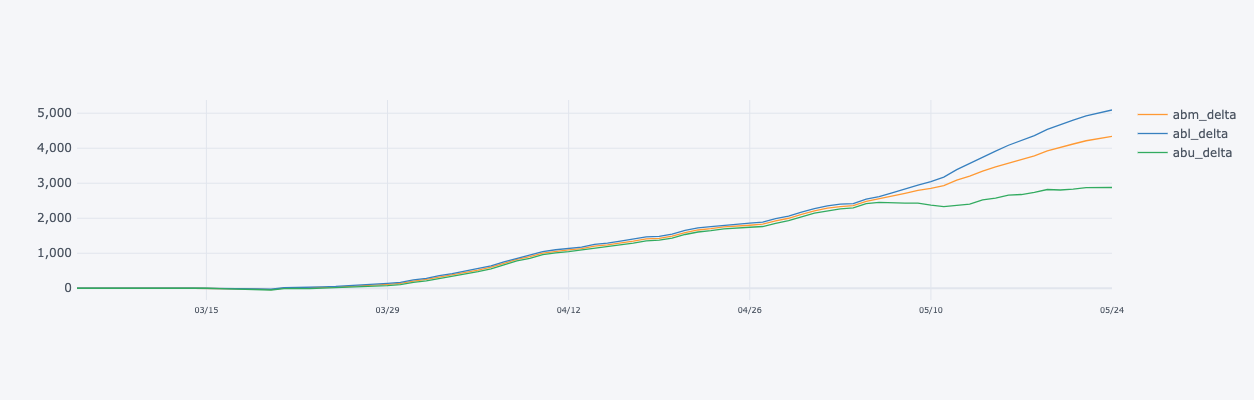

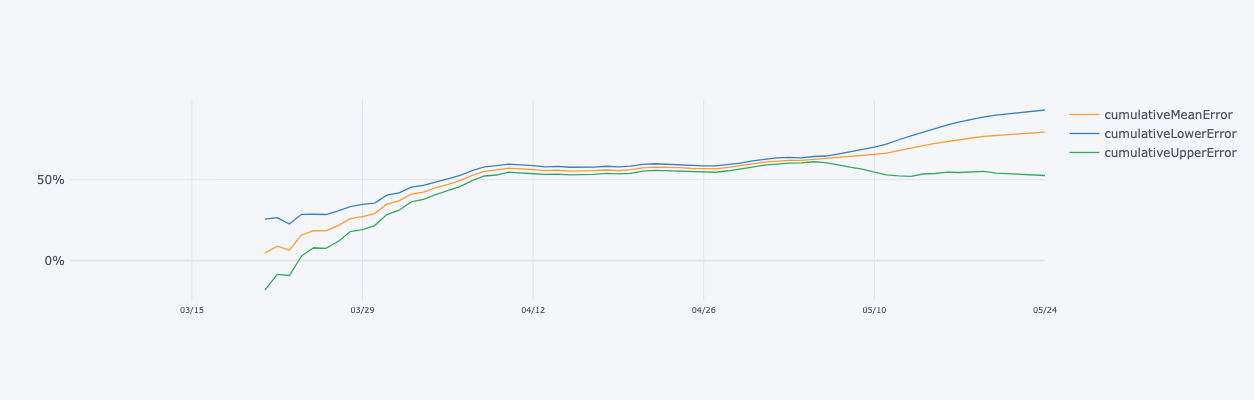

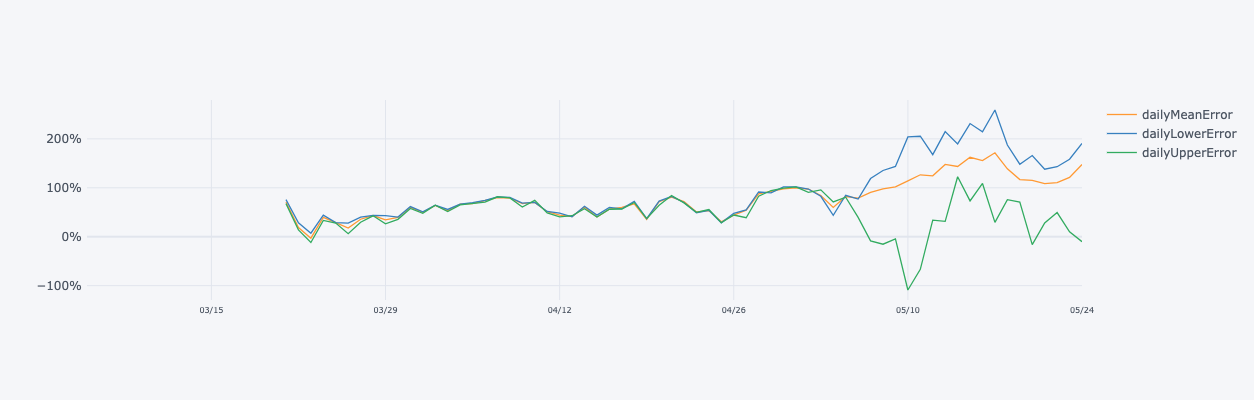

In [8]:
tn_beds_delta = tn_beds[['abm_delta', 'abl_delta', 'abu_delta']]
tn_beds_cumulative_error = tn_beds[['cumulativeMeanError', 'cumulativeLowerError', 'cumulativeUpperError']]
tn_beds_daily_error = tn_beds[['dailyMeanError', 'dailyLowerError', 'dailyUpperError']]

fig = tn_beds_delta.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0,0'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

fig = tn_beds_cumulative_error.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0%'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

fig = tn_beds_daily_error.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0%'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

#tn_df.head()

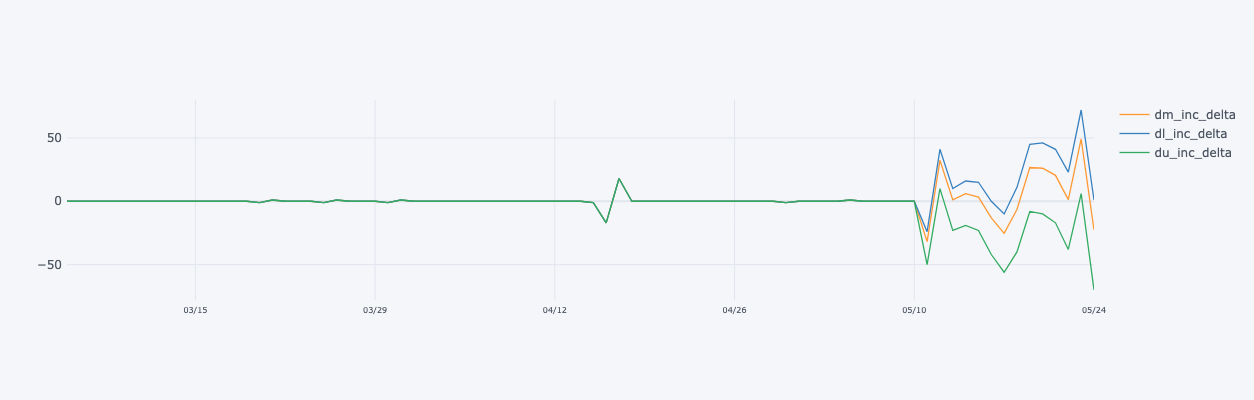

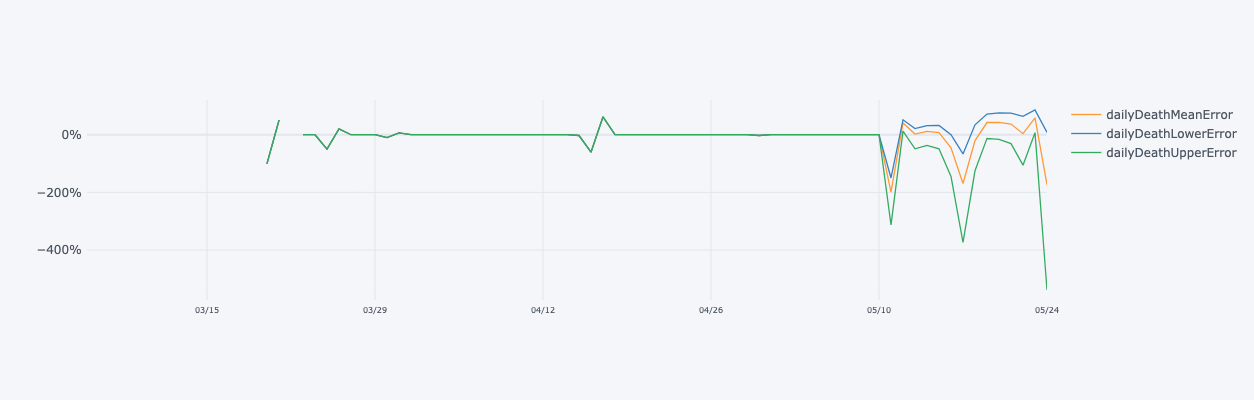

In [9]:
tn_deaths_delta = tn_beds[['dm_inc_delta', 'dl_inc_delta', 'du_inc_delta']] # swapped cumulative for daily based on IHME dataset
#tn_deaths_cumulative_error = tn_beds[['cumDeathMeanError', 'cumDeathLowerError', 'cumDeathUpperError']]
tn_deaths_daily_error = tn_beds[['dailyDeathMeanError', 'dailyDeathLowerError', 'dailyDeathUpperError']]

fig = tn_deaths_delta.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0,0'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

#fig = tn_deaths_cumulative_error.iplot(asFigure=True)
#fig.layout.xaxis.tickformat = '%m/%d'
#fig.layout.xaxis.tickfont.size = 8
#fig.layout.yaxis.tickformat = '0%'
#fig.update_layout(
#    autosize=False,
#    width=600,
#    height=400,
#    margin=dict(
#        l=50,
#        r=50,
#        b=100,
#        t=100,
#        pad=4
#    ),
#)
#fig.show()

fig = tn_deaths_daily_error.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0%'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

#tn_df.head()

In [10]:
panels = []

for state, df, state_population in state_df_list:
    source = ColumnDataSource(data=df)
    
    for axis_type in ["linear", "log"]:
        hover = HoverTool(
            tooltips=[
                ('Date', '@date{%F}'),
                ('Tests', '@totalTestResults{0,0}'),
                ('Positives', '@positive{0,0}'),
            ],
    
            formatters={
                '@date'    : 'datetime',
            },
    
            # display a tooltip whenever the cursor is vertically in line with a glyph
            mode='vline'
        )
        p = figure(x_axis_type="datetime", y_axis_type=axis_type, toolbar_location="above")
        p.line(x='date', y='positive', line_width=2, source=source, legend_label='Cumulative Positive', line_color="red")
        p.line(x='date', y='totalTestResults', line_width=2, source=source, legend_label='Total Tests', line_color="blue")
        p.title.text = 'Cumulative {} Positive Tests vs Total Tests'.format(state)
        p.yaxis.formatter = NumeralTickFormatter(format="0,0")
        p.legend.location = "top_left"
        p.toolbar.autohide = True
        p.add_tools(hover)
    
        panel = Panel(child=p, title=axis_type)
        panels.append(panel)

tabs = Tabs(tabs=panels)
show(tabs)

In [11]:
panels = []

for state, df, state_population in state_df_list:
    source = ColumnDataSource(data=df)
    
    for axis_type in ["linear", "log"]:
        hover = HoverTool(
            tooltips=[
                ('Date', '@date{%F}'),
                ('Hospitalized', '@hospitalized{0,0}'),
                ('Positives', '@positive{0,0}'),
            ],
    
            formatters={
                '@date'    : 'datetime',
            },
    
            # display a tooltip whenever the cursor is vertically in line with a glyph
            mode='vline'
        )
        p = figure(x_axis_type="datetime", y_axis_type=axis_type, toolbar_location="above")
        p.line(x='date', y='positive', line_width=2, source=source, legend_label='Cumulative Positive', line_color="blue")
        p.line(x='date', y='hospitalized', line_width=2, source=source, legend_label='Hospitalizations', line_color="red")
        p.title.text = 'Cumulative {} Positive Tests vs Hospitalizations'.format(state)
        p.yaxis.formatter = NumeralTickFormatter(format="0,0")
        p.legend.location = "top_left"
        p.toolbar.autohide = True
        p.add_tools(hover)
    
        panel = Panel(child=p, title=axis_type)
        panels.append(panel)

tabs = Tabs(tabs=panels)
show(tabs)

In [12]:
panels = []

for state, df, state_population in state_df_list:
    source = ColumnDataSource(data=df)
    
    for axis_type in ["linear", "log"]:
        hover = HoverTool(
            tooltips=[
                ('Date', '@date{%F}'),
                ('Deaths', '@death{0,0}'),
                ('Positives', '@positive{0,0}'),
            ],
    
            formatters={
                '@date'    : 'datetime',
            },
    
            # display a tooltip whenever the cursor is vertically in line with a glyph
            mode='vline'
        )
        p = figure(x_axis_type="datetime", y_axis_type=axis_type, toolbar_location="above")
        p.line(x='date', y='positive', line_width=2, source=source, legend_label='Cumulative Positive', line_color="blue")
        p.line(x='date', y='death', line_width=2, source=source, legend_label='Cumulative Deaths', line_color="red")
        p.title.text = 'Cumulative {} Positive Tests vs Deaths'.format(state)
        p.yaxis.formatter = NumeralTickFormatter(format="0,0")
        p.legend.location = "top_left"
        p.toolbar.autohide = True
        p.add_tools(hover)
    
        panel = Panel(child=p, title=axis_type)
        panels.append(panel)

tabs = Tabs(tabs=panels)
show(tabs)

In [13]:
panels = []

for state, df, state_population in state_df_list:
    source = ColumnDataSource(data=df)
    
    for axis_type in ["linear", "log"]:
        hover = HoverTool(
            tooltips=[
                ('Date', '@date{%F}'),
                ('Infection Rate', '@infectionRate{0.0000%}'),
                ('Hospitalization Rate', '@totalHospitalRate{0.0000%}'),
                ('Death Rate', '@totalDeathRate{0.0000%}'),
            ],
    
            formatters={
                '@date'    : 'datetime',
            },
    
            # display a tooltip whenever the cursor is vertically in line with a glyph
            mode='vline'
        )
        p = figure(x_axis_type="datetime", y_axis_type=axis_type, toolbar_location="above")
        p.line(x='date', y='infectionRate', line_width=2, source=source, legend_label='Infection Rate', line_color="blue")
        p.line(x='date', y='totalHospitalRate', line_width=2, source=source, legend_label='Hospital Rate', line_color="green")
        p.line(x='date', y='totalDeathRate', line_width=2, source=source, legend_label='Death Rate', line_color="red")
        p.title.text = '{} Infection Rate vs Hospital Rate vs Death Rate'.format(state)
        p.yaxis.formatter = NumeralTickFormatter(format="0.0000%")
        p.legend.location = "top_left"
        p.toolbar.autohide = True
        p.add_tools(hover)
    
        panel = Panel(child=p, title=axis_type)
        panels.append(panel)

tabs = Tabs(tabs=panels)
show(tabs)

In [14]:
panels = []


    
for axis_type in ["linear", "log"]:
    hover = HoverTool(
        tooltips=[
            ('Date', '@date{%F}'),
            ('Infection Rate', '@infectionRate{0.0000%}'),
        ],
    
        formatters={
            '@date'    : 'datetime',
        },
    
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
    )
    p = figure(x_axis_type="datetime", y_axis_type=axis_type, toolbar_location="above")
    for state, df, state_population in state_df_list:
        source = ColumnDataSource(data=df)
        p.line(x='date', y='infectionRate', line_width=2, source=source, legend_label=state, line_color="blue")
    p.title.text = 'Infection Rate by State'
    p.yaxis.formatter = NumeralTickFormatter(format="0.0000%")
    p.legend.location = "top_left"
    p.toolbar.autohide = True
    p.add_tools(hover)

    panel = Panel(child=p, title=axis_type)
    panels.append(panel)

tabs = Tabs(tabs=panels)
show(tabs)

In [15]:
panels = []

hover = HoverTool(
    tooltips=[
        ('Date', '@date{%F}'),
        ('Positives', '@positiveIncrease{0,0}'),
    ],
    
    formatters={
        '@date'    : 'datetime',
    },
)

p = figure(x_axis_type="datetime", toolbar_location="above")
for state, df, state_population in state_df_list:
    source = ColumnDataSource(data=df)
    p.vbar(x='date', top='positiveIncrease', source=source, width=timedelta(hours=12))
    p.yaxis.axis_label = "Daily Positive Test Results"
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    p.title.text = "{} Positive Results by Day".format(state)
    p.toolbar.autohide = True
    p.add_tools(hover)
    p.xaxis.ticker.num_minor_ticks = 6
    

show(p)

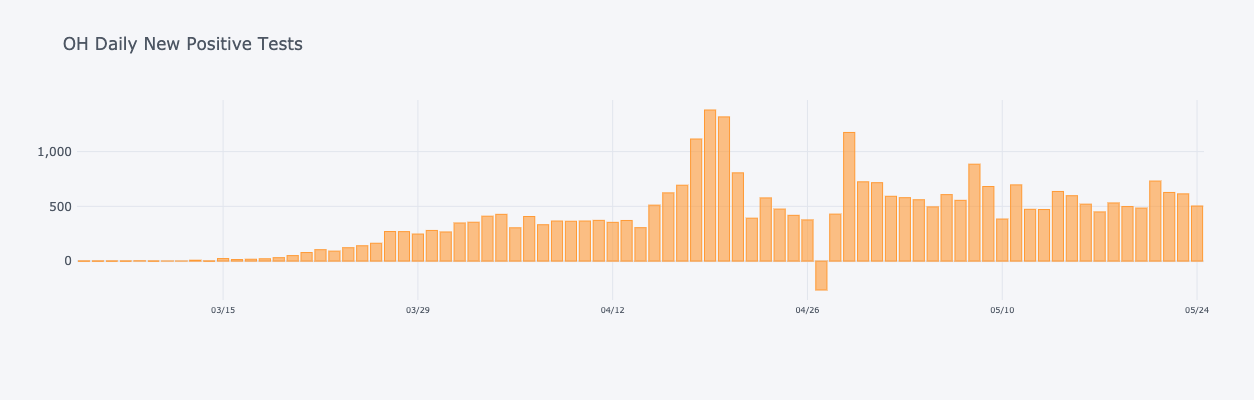

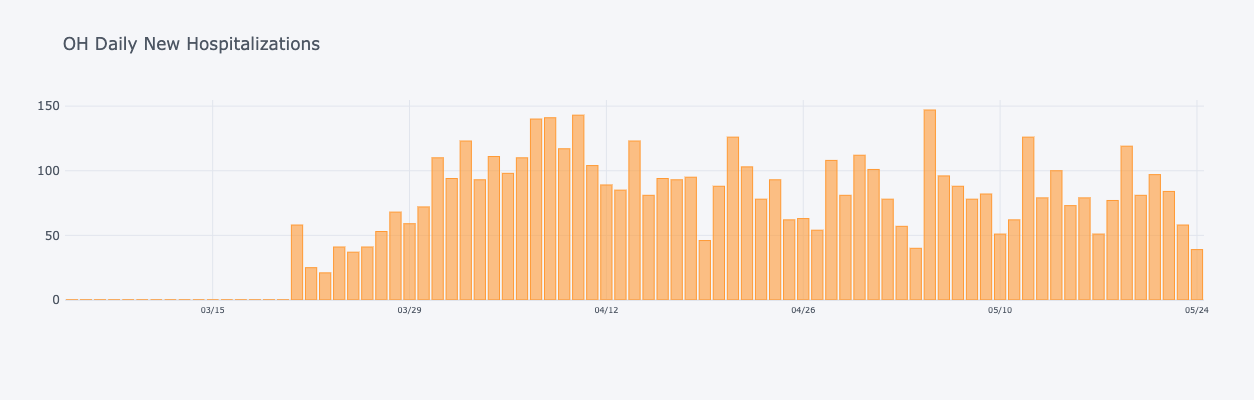

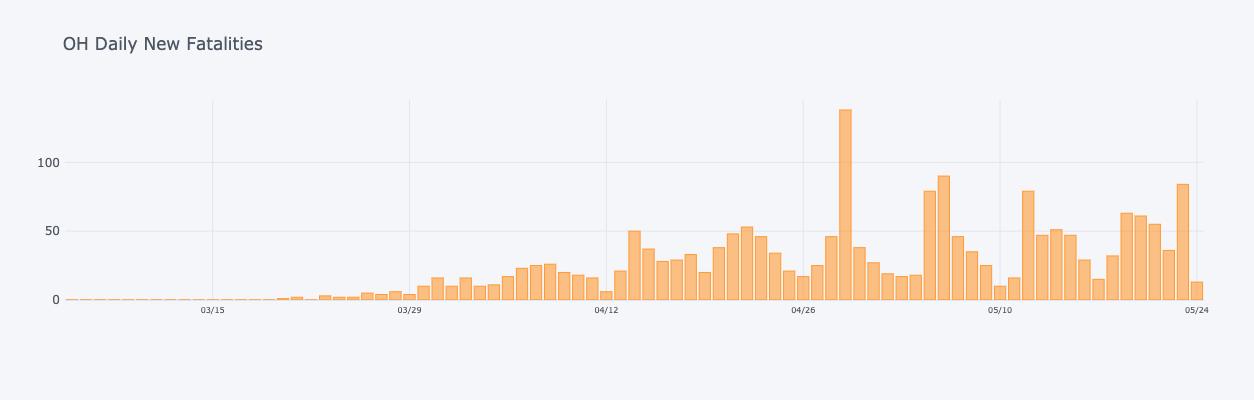

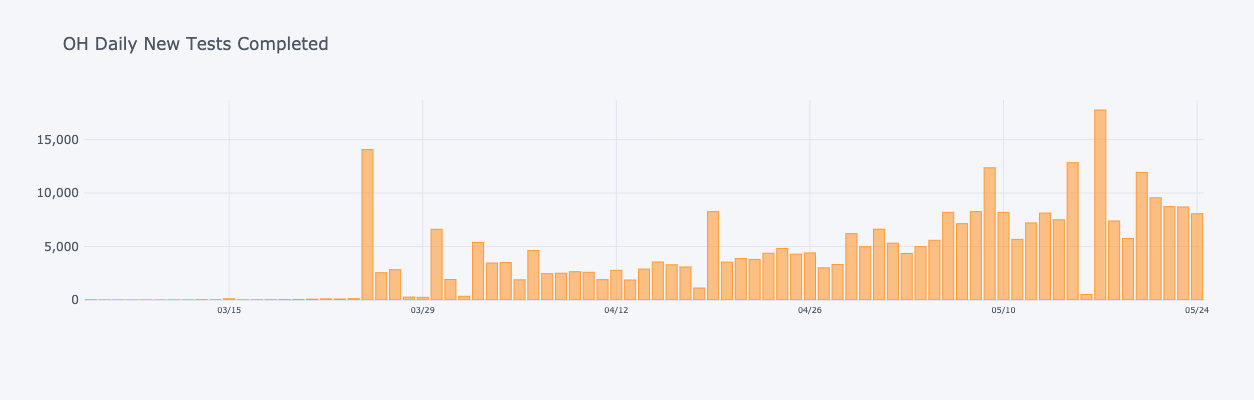

In [16]:
for stat, title in [('positiveIncrease', 'Positive Tests'),
             ('hospitalizedIncrease', 'Hospitalizations'),
             ('deathIncrease', 'Fatalities'),
             ('totalTestResultsIncrease', 'Tests Completed'),
            ]:
    for state, df, state_population in state_df_list:
        new_df = df[['date', stat]].set_index('date')
        fig = new_df.iplot(asFigure=True, kind="bar", title='{} Daily New {}'.format(state, title))
        fig.layout.xaxis.tickformat = '%m/%d'
        fig.layout.xaxis.tickfont.size = 8
        fig.layout.yaxis.tickformat = '0,0'
        fig.update_layout(
            autosize=False,
            width=600,
            height=400,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4
            ),
        )
    fig.show()

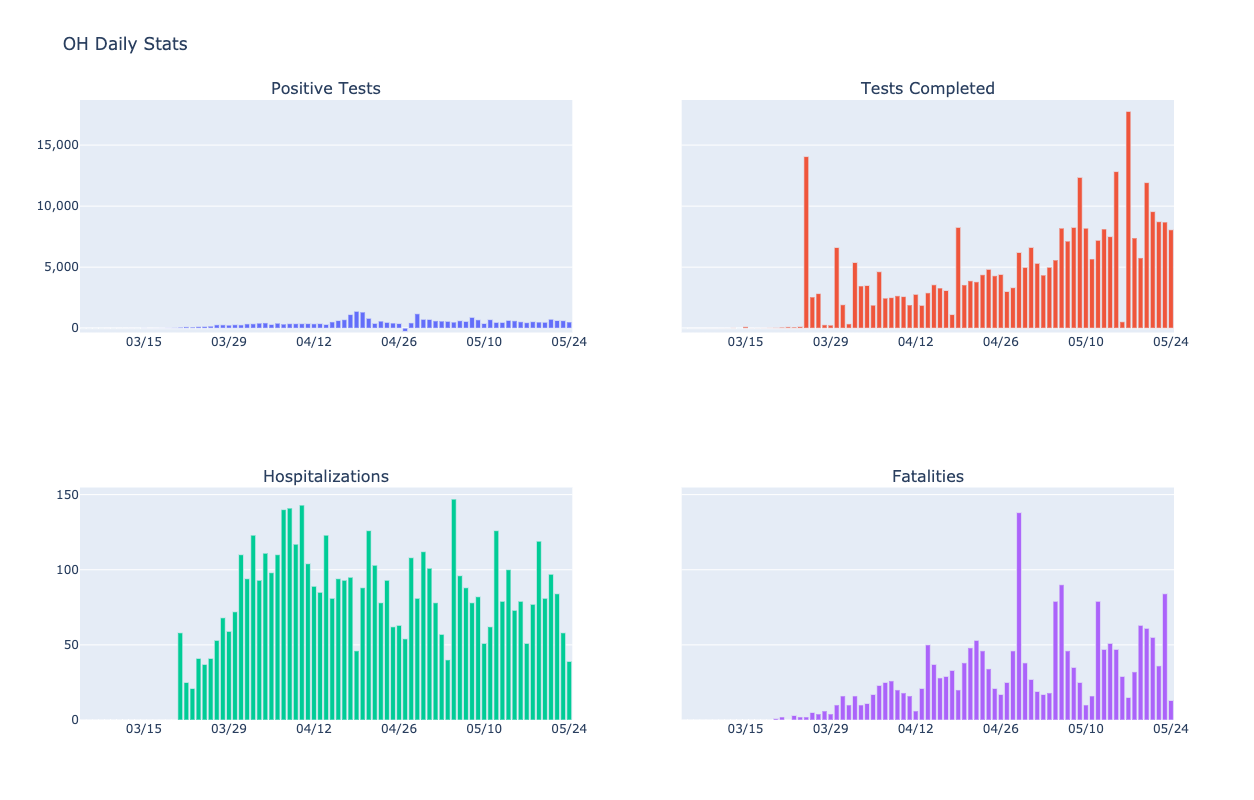

In [17]:
for state, df, state_population in state_df_list:
    new_df = df[['date', 'positiveIncrease', 'hospitalizedIncrease', 'deathIncrease', 'totalTestResultsIncrease']].set_index('date')

    graph_datapoints = [('positiveIncrease', 'Positive Tests'),
                        ('totalTestResultsIncrease', 'Tests Completed'),
                        ('hospitalizedIncrease', 'Hospitalizations'),
                        ('deathIncrease', 'Fatalities'),
                       ]

    # Initialize figure with subplots
    fig = make_subplots(rows=2, 
                        cols=2, 
                        shared_yaxes=True,
                        subplot_titles=(graph_datapoints[0][1], graph_datapoints[1][1], graph_datapoints[2][1], graph_datapoints[3][1]),
                       )

    # Add Traces
    fig.add_trace(go.Bar(x=new_df.index, y=new_df.positiveIncrease), row=1, col=1)
    fig.add_trace(go.Bar(x=new_df.index, y=new_df.totalTestResultsIncrease), row=1, col=2)
    fig.add_trace(go.Bar(x=new_df.index, y=new_df.hospitalizedIncrease), row=2, col=1)
    fig.add_trace(go.Bar(x=new_df.index, y=new_df.deathIncrease), row=2, col=2)

    
    # Update X Axis Properties
    fig.update_xaxes(tickformat='%m/%d', row=1, col=1)
    fig.update_xaxes(tickformat='%m/%d', row=1, col=2)
    fig.update_xaxes(tickformat='%m/%d', row=2, col=1)
    fig.update_xaxes(tickformat='%m/%d', row=2, col=2)
    
    # Update Y Axis Properties
    fig.update_yaxes(tickformat='0,0', row=1, col=1)
    fig.update_yaxes(tickformat='0,0', row=1, col=2)
    fig.update_yaxes(tickformat='0,0', row=2, col=1)
    fig.update_yaxes(tickformat='0,0', row=2, col=2)
    
    fig.update_layout(title_text="{} Daily Stats".format(state), showlegend=False, height=800, width=800)

    fig.show()

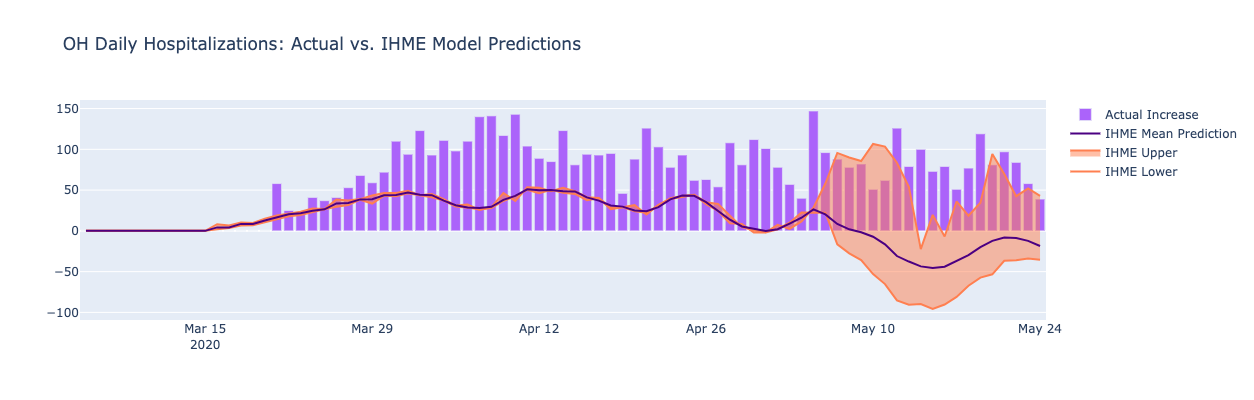

In [18]:
for state in states:

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.ablInc,
        fill=None,
        mode='lines',
        line_color='coral',
        name='IHME Lower',
        ))
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.abuInc,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines',
        line_color='coral',
        name='IHME Upper',
        ))
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.abmInc,
        line_color='indigo',
        name='IHME Mean Prediction',
        ))
    fig.add_trace(go.Bar(x=tn_beds.index, y=tn_beds.hospInc,
        name='Actual Increase',
        ))
    fig.update_layout(title_text="{} Daily Hospitalizations: Actual vs. IHME Model Predictions".format(state), height=400, width=600)
    
    fig.show()

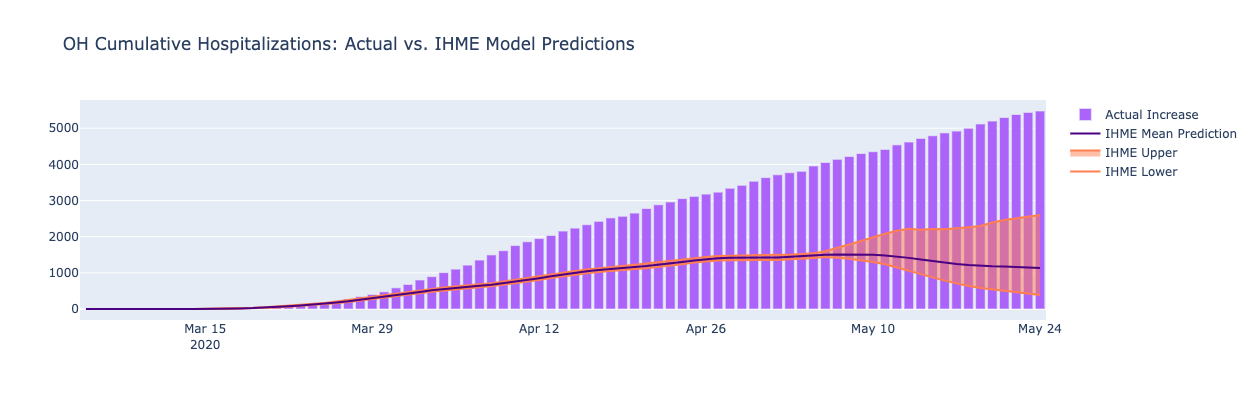

In [19]:
for state in states:

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.allbed_lower,
        fill=None,
        mode='lines',
        line_color='coral',
        name='IHME Lower',
        ))
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.allbed_upper,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines',
        line_color='coral',
        name='IHME Upper',
        ))
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.allbed_mean,
        line_color='indigo',
        name='IHME Mean Prediction',
        ))
    fig.add_trace(go.Bar(x=tn_beds.index, y=tn_beds.hospitalizedCumulative,
        name='Actual Increase',
        ))
    fig.update_layout(title_text="{} Cumulative Hospitalizations: Actual vs. IHME Model Predictions".format(state), height=400, width=600)
    
    fig.show()

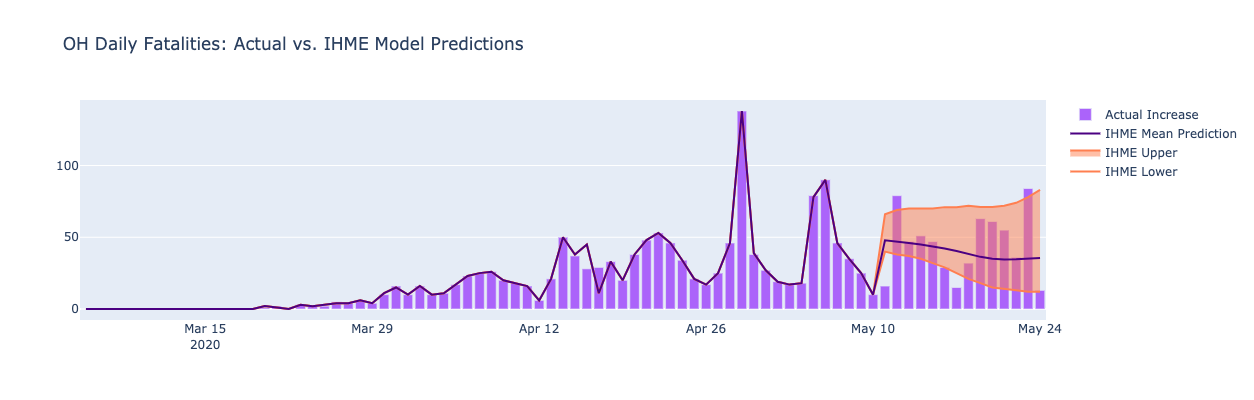

In [20]:
for state in states:

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.deaths_lower,
        fill=None,
        mode='lines',
        line_color='coral',
        name='IHME Lower',
        ))
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.deaths_upper,
        fill='tonexty', # fill area between trace0 and trace1
        mode='lines',
        line_color='coral',
        name='IHME Upper',
        ))
    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.deaths_mean,
        line_color='indigo',
        name='IHME Mean Prediction',
        ))
    fig.add_trace(go.Bar(x=tn_beds.index, y=tn_beds.deathIncrease,
        name='Actual Increase',
        ))
    fig.update_layout(title_text="{} Daily Fatalities: Actual vs. IHME Model Predictions".format(state), height=400, width=600)
    
    fig.show()

In [21]:
#for state in states:

#    fig = go.Figure()
#    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.deaths_lower,
#        fill=None,
#        mode='lines',
#        line_color='coral',
#        name='IMHE Lower',
#        ))
#    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.deaths_upper,
#        fill='tonexty', # fill area between trace0 and trace1
#        mode='lines',
#        line_color='coral',
#        name='IMHE Upper',
#        ))
#    fig.add_trace(go.Scatter(x=tn_beds.index, y=tn_beds.deaths_mean,
#        line_color='indigo',
#        name='IMHE Mean Prediction',
#        ))
#    fig.add_trace(go.Bar(x=tn_beds.index, y=tn_beds.death,
#        name='Actual Deaths',
#        ))
#    fig.update_layout(title_text="{} Daily Fatalities: Actual vs. IMHE Model Predictions".format(state), height=400, width=600)
#    
#    fig.show()